In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

In [2]:
%%stata -qui

use "../data/data", clear
rename log_flesch_kincaid_grade_level FKG
quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals  ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

## Poisson Regression

We are interested in modelling the number of sentences in an abstract in excess of 3 (5\% of articles have at most 3 sentences), i.e., our model is
$$
\mathbb{E}[\texttt{Excess Sentences}|\texttt{log(Number authors)},\texttt{log(Number pages)},\texttt{Both genders},\texttt{Proportion women}]\\\
= \exp{\left(\beta_1\log(\text{Number authors})+\beta_2\log(\text{Number pages})+\beta_3\texttt{Both genders}+\theta\texttt{Proportion women}\right.}\\\
\left.+\texttt{Journals}+\texttt{JEL codes}+\texttt{Cluster}+\texttt{Years}+\texttt{JEL flag}+\beta_{272}\right)
$$

In [3]:
%%stata -qui
summarize num_sentences, detail
local cutoff_sentences = r(p5)
gen int excess_sentences = num_sentences - `cutoff_sentences'
replace excess_sentences = 0 if excess_sentences < 0


. set scheme gg_jet

. histogram excess_sentences, discrete freq width(1) xtitle("Number of Sentence
> s in Excess of 3")
(start=0, width=1)

. 


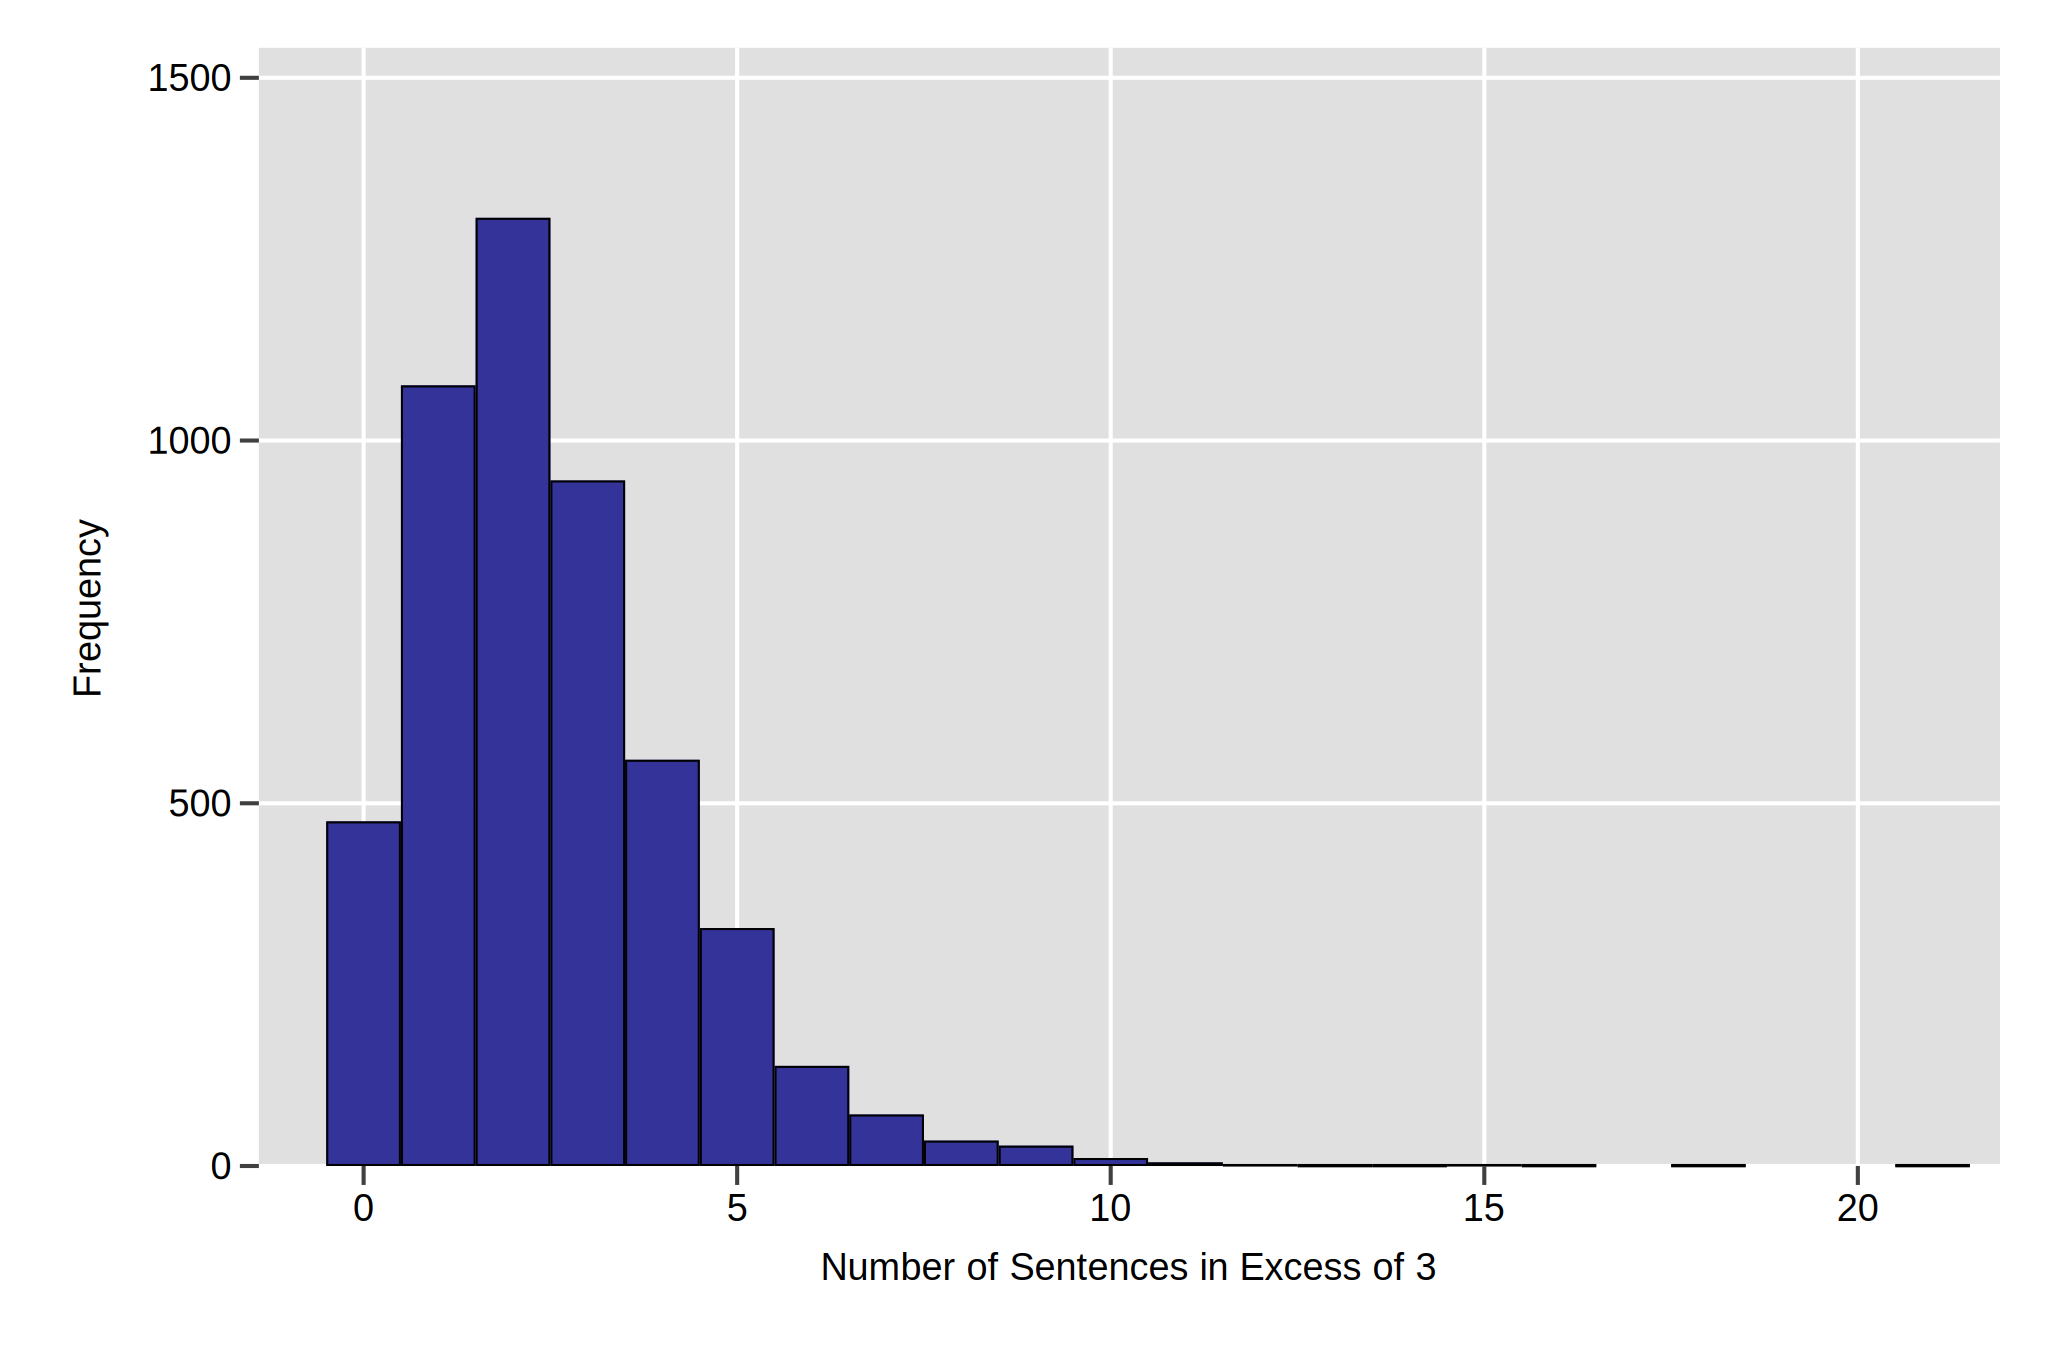

In [4]:
%%stata
set scheme gg_jet
histogram excess_sentences, discrete freq width(1) xtitle("Number of Sentences in Excess of 3")

In [5]:
%%stata -qui
#delimit ;
poisson excess_sentences log_num_authors log_num_pages both_genders prop_women
			          `journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(cluster cluster);
#delimit cr

In [6]:
%%stata
estimates table, keep(log_num_authors log_num_pages both_genders prop_women jel_flag) b(%5.4f) star varwidth(50) varlabel


-----------------------------------------------------------------
                                          Variable |   Active    
---------------------------------------------------+-------------
                Logarithm of the number of authors | -0.0118     
                  Logarithm of the number of pages |  0.4093***  
    Indicator if author team includes both genders |  0.0004     
             Proportion of women among the authors |  0.0416*    
Indicator of whether the article includes a JEL cl |  0.0349*    
-----------------------------------------------------------------
                         Legend: * p<0.05; ** p<0.01; *** p<0.001


In [7]:
%%stata
nlcom (_b[log_num_pages]) (100*_b[prop_women]) (100*(exp(_b[jel_flag])-1))


       _nl_1: _b[log_num_pages]
       _nl_2: 100*_b[prop_women]
       _nl_3: 100*(exp(_b[jel_flag])-1)

------------------------------------------------------------------------------
excess_sen~s | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _nl_1 |   .4093298   .0162724    25.15   0.000     .3774364    .4412231
       _nl_2 |   4.157834   2.077484     2.00   0.045     .0860391    8.229628
       _nl_3 |    3.54721   1.444164     2.46   0.014     .7166994     6.37772
------------------------------------------------------------------------------


Other factors equal:
* The _elasticity_ of the expected number of sentences in excess of 3 for an article's abstract with respect to the article's number of pages is 0.41.
* If an article's authors are all women (```prop_women``` goes from 0 to 1), the abstract's expected number of sentences in excess of 3 increase by 4.16\%.
* The expected number of sentences in excess of 3 for an article's abstract is roughly 3.55\% higher when the JEL is imputed ceteris paribus.

## High-Dimensional Fixed Effects

In [8]:
%%stata -qui
egen journal1 = group(journal)
#delimit ;
ppmlhdfe excess_sentences log_num_authors log_num_pages both_genders prop_women,
                          absorb(journal1 a_imp b_imp c_imp  e_imp f_imp g_imp h_imp
                                i_imp j_imp k_imp l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp
                                year ib0.cluster jel_flag) vce(cluster cluster);
#delimit cr

In [9]:
%%stata
#delimit ;
estimates table, keep(log_num_authors log_num_pages both_genders prop_women)
                 b(%5.4f) star varwidth(50) varlabel;
#delimit cr


. #delimit ;
delimiter now ;
. estimates table, keep(log_num_authors log_num_pages both_genders prop_women)
>                  b(%5.4f) star varwidth(50) varlabel;

-----------------------------------------------------------------
                                          Variable |   Active    
---------------------------------------------------+-------------
                Logarithm of the number of authors | -0.0118     
                  Logarithm of the number of pages |  0.4093***  
    Indicator if author team includes both genders |  0.0004     
             Proportion of women among the authors |  0.0416*    
-----------------------------------------------------------------
                         Legend: * p<0.05; ** p<0.01; *** p<0.001

. #delimit cr
delimiter now cr
. 


## Specification Curve Analysis

Clearing the data set in memory, reloading, and creating the ```journal1``` variable

In [10]:
%%stata -qui

clear all
use "../data/data", clear
egen journal1 = group(journal)

summarize num_sentences, detail
local cutoff_sentences = r(p5)
gen int excess_sentences = num_sentences - `cutoff_sentences'
replace excess_sentences = 0 if excess_sentences < 0

Commenting out the ```- log(F-K grade): log_flesch_kincaid_grade_level``` line in the ```.yml``` file.

In [11]:
import yaml

# File name
file_path = '../code/readability_graph_specurve.yml'

# Read, modify, and save the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Modify the target line
modified_lines = []
for line in lines:
    if line.strip() == "- log(F-K grade): log_flesch_kincaid_grade_level":
        modified_lines.append(f"#     {line}")  # Comment out the line
    else:
        modified_lines.append(line)

# Write the modified content back to the file
with open(file_path, 'w') as file:
    file.writelines(modified_lines)

print("Line commented successfully!")

FileNotFoundError: [Errno 2] No such file or directory: '../code/readability_graph_specurve.yml'

In [ ]:
# File name
file_path = '../code/readability_graph_specurve.yml'

# Read, modify, and save the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Modify the target line
modified_lines = []
for line in lines:
    stripped_line = line.strip()
    if stripped_line.startswith("#     - Excess Sentences: excess_sentences"):
        # Uncomment the line
        modified_lines.append(line.replace("#     -", "-"))  # Replace `#-` with `-`
    else:
        modified_lines.append(line)

# Write the modified content back to the file
with open(file_path, 'w') as file:
    file.writelines(modified_lines)

print("Line uncommented successfully if it was commented!")

Creating the specification curve by concentratng on the effect of ```prop_women``` on the count outcome variable ```excess_sentences```, by always controlling for the following regressors: ```both_genders```, ```log_num_authors```, ```log_num_pages```, and ```jel_flag```.

In [ ]:
%%stata
#delimit ;
quietly specurve using "readability_graph_specurve.yml", cmd(ppmlhdfe)
        desc noci99 width(8) height(10) relativesize(0.4)
        scale(0.7) title("Specification Curve Analsyis of Proportion of Women");
#delimit crs

In [ ]:
# File name
file_path = '../code/readability_graph_specurve.yml'

# Read, modify, and save the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Modify the target line
modified_lines = []
for line in lines:
    if line.strip() == "- Excess Sentences: excess_sentences":
        modified_lines.append(f"#     {line}")  # Comment out the line
    else:
        modified_lines.append(line)

# Write the modified content back to the file
with open(file_path, 'w') as file:
    file.writelines(modified_lines)

print("Line commented successfully!")

In [ ]:
# File name
file_path = '../code/readability_graph_specurve.yml'

# Read, modify, and save the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Modify the target line
modified_lines = []
for line in lines:
    stripped_line = line.strip()
    if stripped_line.startswith("#     - log(F-K grade): log_flesch_kincaid_grade_level"):
        # Uncomment the line
        modified_lines.append(line.replace("#     -", "-"))  # Replace `#-` with `-`
    else:
        modified_lines.append(line)

# Write the modified content back to the file
with open(file_path, 'w') as file:
    file.writelines(modified_lines)

print("Line uncommented successfully if it was commented!")

## Marginal Effects

In [ ]:
%%stata -qui

use "../data/data", clear

quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

summarize num_sentences, detail
local cutoff_sentences = r(p5)
gen int excess_sentences = num_sentences - `cutoff_sentences'
replace excess_sentences = 0 if excess_sentences < 0

In [ ]:
%%stata -qui
#delimit ;
vl set log_num_authors log_num_pages both_genders prop_women
       `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
       , dummy clear nonotes;
vl create fe = vldummy - (both_genders jel_flag);
vl substitute mfe = i.fe;
vl create controls = vlcontinuous - (prop_women);
vl create controls_dummy = (both_genders jel_flag);
vl substitute baseline = i.controls_dummy controls;
vl rebuild;
#delimit cr

In [ ]:
%%stata -qui
#delimit ;
ppmlhdfe excess_sentences prop_women $baseline,
                          absorb($mfe)  vce(cluster cluster) d;
#delimit cr

In [ ]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders prop_women) b(%5.4f) star varwidth(25)

In [ ]:
%%stata -qui
#delimit ;
margins, dydx(prop_women) at(prop_women=(0(0.25)1)
                             log_num_pages=3.463461
                             log_num_authors=0.60205999132 (base) _factor);
#delimit cr

In [ ]:
%%stata
set scheme gg_piyg
marginsplot, yline(0) recast(line) title("Marginal Effects of Proportion of Women")